# Training Procedure Comparison Vanilla PNN to Mining Gold

### Import Modules

In [1]:
import os
from typing import Any

import imageio.v3 as iio
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
from torch.distributions import Normal
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from pytorch_lightning.trainer import Trainer

## 1. Define Dataset


In [2]:
class GoldGenerator(Dataset):
    def __init__(self) -> None:
        super().__init__()

        # seed
        torch.random.seed()

        # dataset
        self.dataset = {}

        # num of points and generations
        self.data_points = 100
        self.generations = 100

        # theta hypothesis
        param_size = 1
        theta_0 = 0.0
        theta_1 = torch.linspace(1, 1, param_size)

        # std for data generation
        x_std = 0.1
        z_std = 1.0

        for gen_idx in range(self.generations):
            # select random theta_1
            theta_1_param = theta_1[torch.randint(0, param_size, size=(1,))[0]]

            # distributions
            dist_0 = Normal(loc=theta_0, scale=z_std)
            dist_1 = Normal(loc=theta_1_param, scale=z_std)

            # target labels and parameter thetas
            theta_0_tensor = torch.zeros(self.data_points)
            theta_1_tensor = torch.ones(self.data_points)
            y = torch.vstack([theta_0_tensor[:int(self.data_points/2)],
                              theta_1_tensor[:int(self.data_points/2)]])

            # empty tensors
            X = torch.empty((self.data_points, 3))
            Y = torch.empty((self.data_points, 2))

            # from theta_0
            z0 = dist_0.rsample((int(self.data_points/2),))
            # from theta_1
            z1 = dist_1.rsample((int(self.data_points/2),))
            Z = torch.vstack([z0, z1])

            # from z0
            x0 = Normal(loc=z0, scale=x_std).rsample((1,))
            # from z1
            x1 = Normal(loc=z1, scale=x_std).rsample((1,))
            x = torch.hstack([x0, x1]).reshape((self.data_points,))
            X[:, 0] = x
            X[:, 1] = theta_0_tensor
            X[:, 2] = theta_1_tensor * theta_1_param  # for paramterization

            # ratio calculation
            r_xz = dist_0.log_prob(Z) - dist_1.log_prob(Z)

            # targets
            Y[:, 0] = y.reshape((self.data_points,))
            Y[:, 1] = r_xz.reshape((self.data_points,))

            self.dataset[gen_idx] = (X, Y)

    def __len__(self):
        return self.generations

    def __getitem__(self, index):
        return self.dataset[index][0], self.dataset[index][1]

## 2. Define Model

In [3]:
class Model(pl.LightningModule):
    def __init__(self,
                 mode: str = "vanilla", # or mining
                 generate_gif = False) -> None:
        super().__init__()

        # mode 
        if mode not in ["vanilla", "mining"]:
            raise Exception("Unknown mode.")
            
        self.mode = mode


        # generate gif
        self.generate_gif = generate_gif

        # total loss on epoch end
        self.total_loss = [] # specific
        self.mse_error_history = [] # mse for all
        self.epoch_end = False

        self.net = nn.Sequential(
            nn.Linear(3, 10),
            nn.PReLU(),
            nn.Linear(10, 10),
            nn.PReLU(),
            nn.Linear(10, 10),
            nn.PReLU(),
            nn.Linear(10, 1)
        )

    def forward(self, x) -> Any:
        output = self.net(x)
        return output

    def configure_optimizers(self):
        optim = Adam(self.parameters())
        return optim

    def training_step(self, train_batch, batch_idx):
        
        # due to the different loss function 
        # this must be splitted into two cases

        # MINING MODEL
        if self.mode == "mining":

            X, Y = train_batch

            # output of the model
            ratio_hat = self.net(X).view(-1).exp()

            # unpack Y
            targets, ratio = Y[:, :, 0].view(-1), Y[:, :, 1].view(-1).exp()

            # loss function
            loss = 1/ratio.shape[0] * torch.sum(targets * (
                ratio - ratio_hat)**2 + targets * (1/ratio - 1/ratio_hat)**2)
            self.log("train_loss", loss)

            if self.epoch_end is True:
                self.total_loss.append(loss.detach().numpy())
                self.epoch_end = False
            return loss
        
        # VANILLLA
        else:

            X, Y = train_batch
            Y_hat = self.net(X)
            Y_hat = 1/(1 + torch.exp(Y_hat))

            # unpack Y
            targets, _ = Y[:, :, 0].view(-1), Y[:, :, 1].view(-1).exp()

            # loss function
            loss = F.binary_cross_entropy(Y_hat.view(-1), targets)
            self.log("train_loss", loss)

            if self.epoch_end is True:
                self.total_loss.append(loss.detach().numpy())
                self.epoch_end = False
            return loss

    def on_train_epoch_end(self):
        # toggle epoch end for easy loss display
        self.epoch_end = True

        # generating training gif
        if self.generate_gif is True:
            x_min, x_max = -4, 5
            y_min, y_max = -4, 5
            size = 20
            X = torch.empty((size, 3))
            X[:, 0] = torch.linspace(x_min, x_max, size)
            X[:, 1] = torch.zeros(size)
            X[:, 2] = torch.ones(size)

            output = self.net(X).detach().numpy()

            true_log_ratio = Normal(loc=0, scale=1).log_prob(
                X[:, 0]) - Normal(loc=1, scale=1).log_prob(X[:, 0])

            # calculate the mean square error for the picture
            mse_error = np.mean((output.reshape((size,)) - true_log_ratio.detach().numpy().reshape((size,)))**2, axis=0)
            mse_error = np.round(mse_error, 2)
            self.mse_error_history.append(mse_error)

            plt.plot(X[:, 0].detach().numpy(), output,
                     "ro", label="Model Output")
            plt.plot(X[:, 0].detach().numpy(), true_log_ratio.detach(
            ).numpy(), "b-", label="True Log Ratio")
            plt.legend()
            plt.xlabel("X")
            plt.ylabel("Log Likelihood Ratio")
            plt.title(f"Epoch {len(self.total_loss)} with MSE: {mse_error}")
            plt.xlim(x_min, x_max)
            plt.ylim(y_min, y_max)
            plt.savefig(f"frames/train_epoch_{len(self.total_loss)}.png")
            plt.clf()
        return

    def on_train_end(self) -> None:
        if self.generate_gif is True:
            frames = np.stack([iio.imread(f'frames/train_epoch_{epoch}.png')
                               for epoch in range(len(self.total_loss))],
                              axis=0)
            if self.mode == "vanilla":
                iio.imwrite('animations/ratio_training_vanilla.gif', frames)
            else:
                iio.imwrite('animations/ratio_training_mining.gif', frames)
            os.system("cd frames && rm -rf  *.png && cd ..")
        print("GIF DONE")
        return


## 3. Initialize Model

In [4]:
mining_model = Model(mode="mining", generate_gif=True)
vanilla_model = Model(mode="vanilla", generate_gif=True)

## 4. Create Dataset

In [5]:
dataset = GoldGenerator()
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

## 5. Initialize Trainer

In [6]:
trainer_vanilla = Trainer(max_epochs=50)
trainer_mining = Trainer(max_epochs=50)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## 6. Train

### Train on the mining model

In [7]:
trainer_mining.fit(mining_model,dataloader)


  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 274   
------------------------------------
274       Trainable params
0         Non-trainable params
274       Total params
0.001     Total estimated model params size (MB)
/opt/homebrew/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/homebrew/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1938: PossibleUserWarning: The number of training samples (7) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

GIF DONE


<Figure size 432x288 with 0 Axes>

### Train on the vanilla model

In [8]:
trainer_vanilla.fit(vanilla_model, dataloader)


  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 274   
------------------------------------
274       Trainable params
0         Non-trainable params
274       Total params
0.001     Total estimated model params size (MB)
/opt/homebrew/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/homebrew/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1938: PossibleUserWarning: The number of training samples (7) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

GIF DONE


<Figure size 432x288 with 0 Axes>

## 7. Loss Comparison

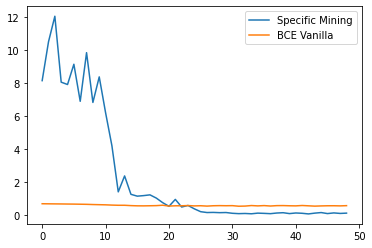

In [9]:
plt.plot(mining_model.total_loss, label = "Specific Mining")
plt.plot(vanilla_model.total_loss, label = "BCE Vanilla")
# plt.semilogy()
plt.legend()
plt.show()

## 8. MSE Comparison GIF

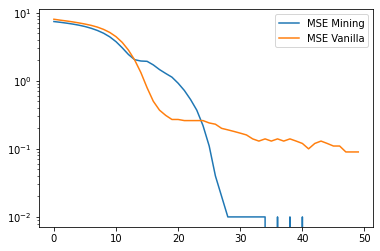

In [11]:
plt.plot(mining_model.mse_error_history, label = "MSE Mining")
plt.plot(vanilla_model.mse_error_history, label = "MSE Vanilla")
plt.semilogy()
plt.legend()
plt.show()